<a href="https://colab.research.google.com/github/KwanJeong/lung_segmentation/blob/main/lung_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import tensorflow as tf
import numpy as np

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D

from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2

In [6]:
IMG_DATA_PATH = "/content/drive/MyDrive/dataset/2d_images"
MASK_DATA_PATH = "/content/drive/MyDrive/dataset/2d_masks"

In [7]:
img_path = sorted(glob.glob(os.path.join(IMG_DATA_PATH, '*.tif')))
mask_path = sorted(glob.glob(os.path.join(MASK_DATA_PATH, '*.tif')))

In [12]:
img_path[:10]

['/content/drive/MyDrive/dataset/2d_images/ID_0000_Z_0142.tif',
 '/content/drive/MyDrive/dataset/2d_images/ID_0001_Z_0146.tif',
 '/content/drive/MyDrive/dataset/2d_images/ID_0002_Z_0162.tif',
 '/content/drive/MyDrive/dataset/2d_images/ID_0003_Z_0132.tif',
 '/content/drive/MyDrive/dataset/2d_images/ID_0004_Z_0066.tif',
 '/content/drive/MyDrive/dataset/2d_images/ID_0005_Z_0066.tif',
 '/content/drive/MyDrive/dataset/2d_images/ID_0006_Z_0206.tif',
 '/content/drive/MyDrive/dataset/2d_images/ID_0007_Z_0211.tif',
 '/content/drive/MyDrive/dataset/2d_images/ID_0008_Z_0065.tif',
 '/content/drive/MyDrive/dataset/2d_images/ID_0009_Z_0114.tif']

In [13]:
mask_path[:10]

['/content/drive/MyDrive/dataset/2d_masks/ID_0000_Z_0142.tif',
 '/content/drive/MyDrive/dataset/2d_masks/ID_0001_Z_0146.tif',
 '/content/drive/MyDrive/dataset/2d_masks/ID_0002_Z_0162.tif',
 '/content/drive/MyDrive/dataset/2d_masks/ID_0003_Z_0132.tif',
 '/content/drive/MyDrive/dataset/2d_masks/ID_0004_Z_0066.tif',
 '/content/drive/MyDrive/dataset/2d_masks/ID_0005_Z_0066.tif',
 '/content/drive/MyDrive/dataset/2d_masks/ID_0006_Z_0206.tif',
 '/content/drive/MyDrive/dataset/2d_masks/ID_0007_Z_0211.tif',
 '/content/drive/MyDrive/dataset/2d_masks/ID_0008_Z_0065.tif',
 '/content/drive/MyDrive/dataset/2d_masks/ID_0009_Z_0114.tif']

In [39]:
imgs = np.stack([cv2.imread(i_path, cv2.IMREAD_UNCHANGED) for i_path in img_path])
print(imgs.shape)
masks = np.stack([cv2.imread(m_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 255. for m_path in mask_path])
print(masks.shape)

(267, 512, 512)
(267, 512, 512)


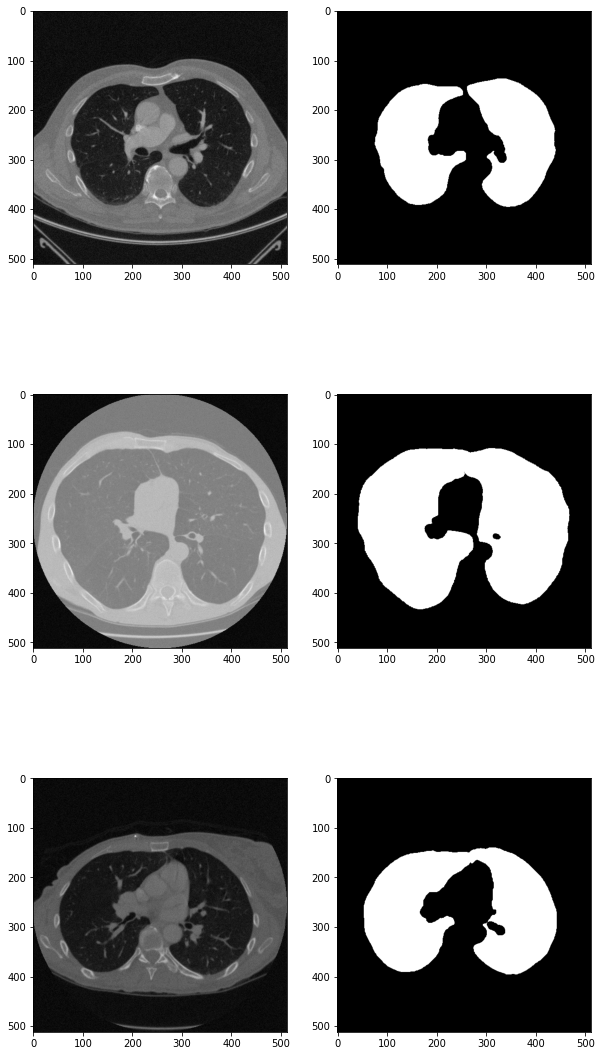

In [40]:
fig, ax = plt.subplots(3, 2, figsize=(10, 20))
for i in range(3):
    ax[i,0].imshow(imgs[i], cmap='gray')
    ax[i,1].imshow(masks[i], cmap='gray')
plt.show()

In [41]:
masks[4, 40:60, 0:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [51]:
imgs = np.reshape(imgs, (len(imgs), -1))
imgs_t = np.transpose(imgs, (1,0))
imgs_t_norm = (imgs_t - np.mean(imgs_t, axis=0)) / np.std(imgs_t, axis=0)
imgs = np.transpose(imgs_t_norm, (1,0))
imgs = np.reshape(imgs, (len(imgs), 512, 512))

In [53]:
# imgs[0]
imgs = imgs[:,:,:,np.newaxis]
masks = masks[:,:,:,np.newaxis]
print(imgs.shape)
print(masks.shape)

(267, 512, 512, 1)
(267, 512, 512, 1)


In [55]:
i_train = imgs[:240]
m_train = masks[:240]
i_val = imgs[-27:]
m_val = masks[-27:]

# Down Sampling

In [56]:
inputs = Input(shape=(512, 512, 1))

net = Conv2D (32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D (64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D (128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D (256, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(256, activation = 'relu')(net)

# Up Sampling

In [57]:
net = UpSampling2D(size=2)(net)
net = Conv2D(256, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation= 'sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation= 'sigmoid', padding='same')(net)

In [59]:
model = Model(inputs = inputs, outputs = outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc','mse'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856 

In [62]:
history = model.fit(i_train, m_train, epochs=100, batch_size=16, validation_data = (i_val, m_val),
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, varbose=1,
                                                mode='auto', min_lr=1e-5)
                    ])

Epoch 1/100
15/15 [==============================] - 15s 622ms/step - loss: 0.5859 - acc: 0.7649 - mse: 0.1916 - val_loss: 0.5569 - val_acc: 0.7621 - val_mse: 0.1840 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 7s 488ms/step - loss: 0.5476 - acc: 0.7650 - mse: 0.1806 - val_loss: 0.5405 - val_acc: 0.7621 - val_mse: 0.1784 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 7s 492ms/step - loss: 0.4994 - acc: 0.7650 - mse: 0.1621 - val_loss: 0.3799 - val_acc: 0.8639 - val_mse: 0.1152 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 7s 499ms/step - loss: 0.3989 - acc: 0.8594 - mse: 0.1188 - val_loss: 0.3322 - val_acc: 0.8965 - val_mse: 0.0918 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 7s 494ms/step - loss: 0.4054 - acc: 0.8556 - mse: 0.1208 - val_loss: 0.3364 - val_acc: 0.8880 - val_mse: 0.0952 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 7s 489ms/step - loss: 0.3630 - acc: 0.8778 - mse: 0.1046

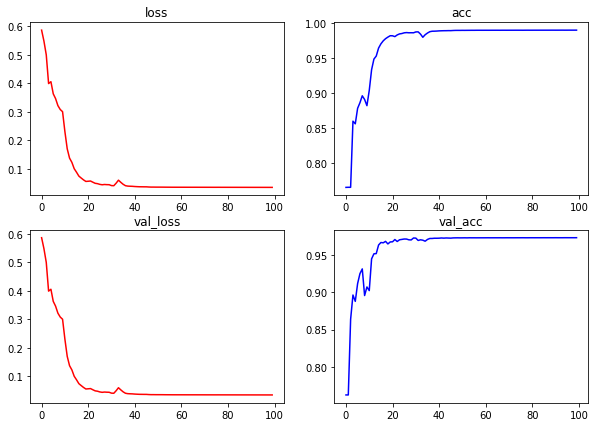

In [64]:
fig, ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].set_title('loss')
ax[0,0].plot(history.history['loss'], 'r')

ax[0,1].set_title('acc')
ax[0,1].plot(history.history['acc'], 'b')

ax[1,0].set_title('val_loss')
ax[1,0].plot(history.history['loss'], 'r')

ax[1,1].set_title('val_acc')
ax[1,1].plot(history.history['val_acc'], 'b')

1/1 [==============================] - 0s 144ms/step


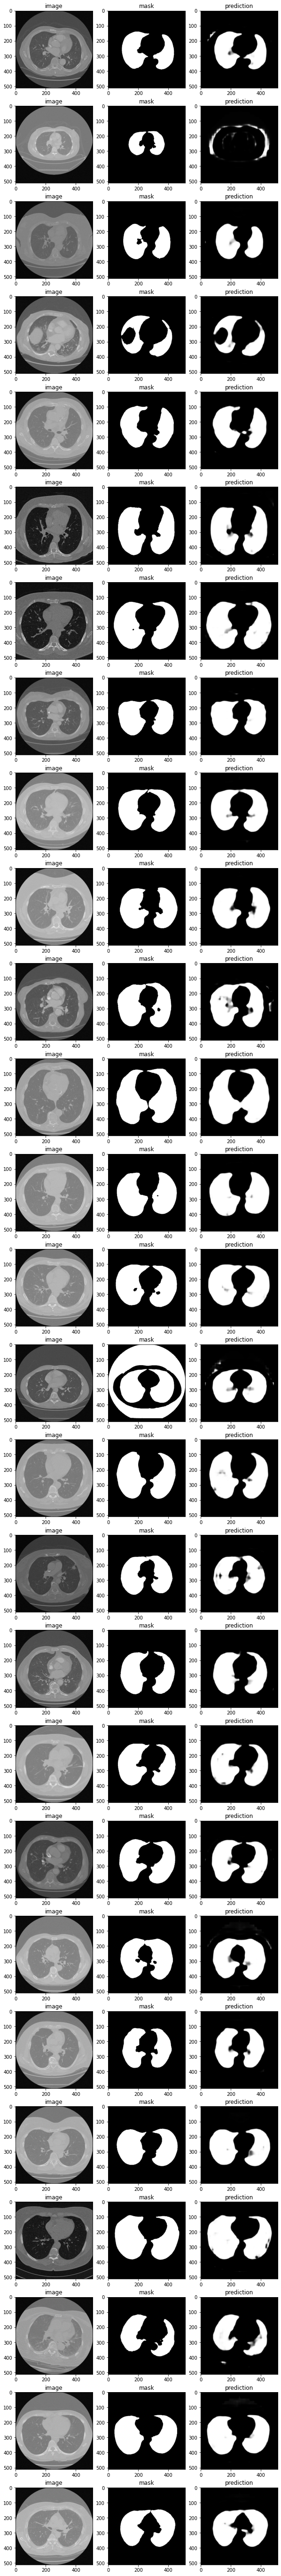

In [68]:
prediction = model.predict(i_val)

fix, ax = plt.subplots(len(i_val),3,figsize=(10,100))

for i,pred in enumerate(prediction):
  ax[i,0].set_title('image')
  ax[i,0].imshow(i_val[i].squeeze(), cmap='gray')
  ax[i,1].set_title('mask')
  ax[i,1].imshow(m_val[i].squeeze(), cmap='gray')
  ax[i,2].set_title('prediction')
  ax[i,2].imshow(pred.squeeze(), cmap='gray')

# Save model and weights

In [70]:
model.save('lung_seg_model.h5')
model.save_weights('lung_seg_weight.h5')